<h1 align="center">Machine Learning and Predictive Analytics</h1>

<h2 align="center">Deep Learning Class Project - Anomaly Detection in Stocks</h2>

<h3 align="center">Roselyn Rozario</h3>

### **Table of Contents** <a class="anchor" id="home"></a>

1. [Import Packages](#Packages)
2. [Dataset](#Dataset)
3. [Exploratory Data Analysis](#EDA)
      * [Pre-Processing](#Pre)
      * [Null Values](#Null)
      * [Data Overview](#Data)
      * [Visuals](#Visuals)
4. [Feature Engineering & Transformations](#Feature)
5. [Modelling Approach](#Model)
      * [Data Preparation](#Preparation)
      * [Base Model (Model I)](#Base)
      * [Improved Model (Model II)](#Improved)
      * [Overfitting/Underfitting Check I](#Check-I)
6. [Anomaly Detection](#Anomaly)
      * [Reconstruction Loss Threshold](#Threshold)
      * [Evaluating Anomalies](#Evaluating)
7. [Results (Model Metrics & Accuracy)](#Results)
      * [Error Metrics](#Error)
      * [Overfitting/Underfitting Check II](#Check-II)

### **Import Packages** <a class="anchor" id="Packages"></a>

In [1]:
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential 

In [2]:
warnings.filterwarnings("ignore")

[Return to Top](#home)

### **Dataset** <a class="anchor" id="Dataset"></a>

Source Link: https://www.kaggle.com/datasets/camnugent/sandp500?select=all_stocks_5yr.csv

Per the dataset source, information in the dataset spans from 2013 to 2018, totalling five years, and includes stock data for S&P 500 companies. All amounts are in USD. 

In [3]:
data = pd.read_csv("all_stocks_5yr.csv")

In [4]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


[Return to Top](#home)

### **Exploratory Data Analysis** <a class="anchor" id="EDA"></a>

Pre-Processing <a class="anchor" id="Pre"></a>

In [5]:
data['date'] = pd.to_datetime(data['date'])

In [6]:
data.columns = data.columns.str.capitalize()

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Null Values <a class="anchor" id="Null"></a>

In [8]:
data.shape

(619040, 7)

In [9]:
data.isnull().sum()

Date       0
Open      11
High       8
Low        8
Close      0
Volume     0
Name       0
dtype: int64

In [10]:
data = data.dropna()
data.shape

(619029, 7)

In [11]:
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


Data Overview <a class="anchor" id="Data"></a>

In [12]:
data['Name'].nunique()

505

In [13]:
data.describe()

,Date,Open,High,Low,Close,Volume
count,619029,619029.00,619029.00,619029.00,619029.00,619029.00
mean,2015-08-18 00:45:31.033280,83.02,83.78,82.26,83.04,4321891.93
min,2013-02-08 00:00:00,1.62,1.69,1.50,1.59,101.00
25%,2014-05-20 00:00:00,40.22,40.62,39.83,40.24,1070351.00
50%,2015-08-21 00:00:00,62.59,63.15,62.02,62.62,2082165.00
75%,2016-11-15 00:00:00,94.37,95.18,93.54,94.41,4284550.00
max,2018-02-07 00:00:00,2044.00,2067.99,2035.11,2049.00,618237630.00
std,NaN,97.38,98.21,96.51,97.39,8693671.06


Visuals <a class="anchor" id="Visuals"></a>

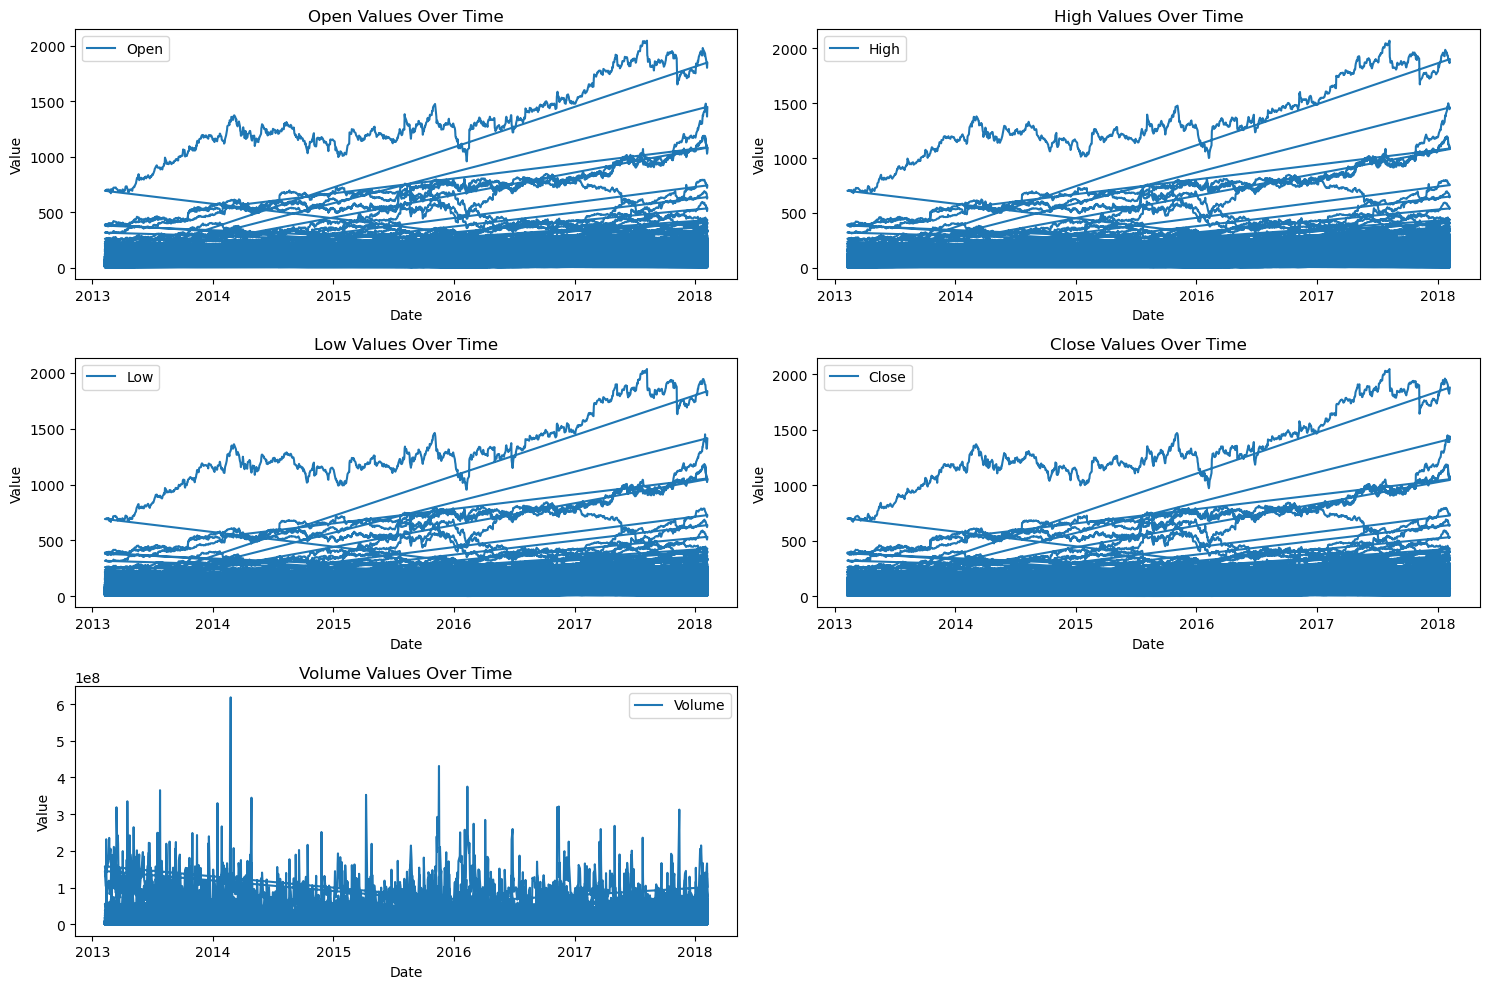

In [14]:
selected = ['Open', 'High', 'Low', 'Close', 'Volume']

fig = plt.figure(figsize=(15, 10))

for i, column in enumerate(selected, 1):
    ax = fig.add_subplot(3, 2, i)
    ax.plot(data['Date'], data[column])
    ax.set_title(f'{column} Values Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend([column])

plt.tight_layout()
plt.show()

[Return to Top](#home)

### **Feature Engineering & Transformations** <a class="anchor" id="Feature"></a>

In [16]:
df = data

In [17]:
# Feature Interactions
df['High_Low_Spread'] = df['High'] - df['Low']
df['Open_Close_Change'] = df['Close'] - df['Open']

In [18]:
df.head()

,Date,Open,High,Low,Close,Volume,Name,High_Low_Spread,Open_Close_Change
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0.49,-0.32
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0.75,-0.43
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,0.41,-0.18
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.69,0.36
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,1.80,-0.95


[Return to Top](#home)

### **Modelling Approach** <a class="anchor" id="Model"></a>

*Data Preparation* <a class="anchor" id="Preparation"></a>

In [19]:
# Features for Model
numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'High_Low_Spread', 'Open_Close_Change']

In [20]:
# Scale Data
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [21]:
# Use NumPy Array for Ease of Use
data_array = df[numerical_features].values

In [22]:
# Reshape Data to 3D Array for Convo1D
data_reshaped = data_array.reshape(data_array.shape[0], 1, data_array.shape[1]) # Assume Each Sample Is A Timestep

In [23]:
# Train/Test Split
train_data, test_data = train_test_split(data_reshaped, test_size=0.2, random_state=12)

In [24]:
print("Train Data - Shape", train_data.shape)
print("Test Data - Shape", test_data.shape)

Train Data - Shape (495223, 1, 7)
Test Data - Shape (123806, 1, 7)


Base Model (Model I) <a class="anchor" id="Base"></a>

In [25]:
model_ = keras.Sequential(
    [
        layers.Input(shape=(train_data.shape[1], train_data.shape[2])),
        layers.Conv1D(
            filters=16,
            kernel_size=5,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=train_data.shape[2],
            kernel_size=5,
            padding="same",
            strides=2,
            activation="relu",
        )
    ]
)
model_.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 16)          │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 2, 7)           │           567 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143 (4.46 KB)

 Trainable params: 1,143 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_ = model_.fit(
    train_data,
    train_data,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 2s 381us/step - loss: 0.3631 - val_loss: 0.1621
Epoch 2/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - loss: 0.2052 - val_loss: 0.1592
Epoch 3/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 345us/step - loss: 0.2027 - val_loss: 0.1590
Epoch 4/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - loss: 0.2007 - val_loss: 0.1580
Epoch 5/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - loss: 0.1984 - val_loss: 0.1598
Epoch 6/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - loss: 0.2035 - val_loss: 0.1586
Epoch 7/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step - loss: 0.2019 - val_loss: 0.1593
Epoch 8/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - loss: 0.1995 - val_loss: 0.1582
Epoch 9/50
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 0.2035 - val_loss: 0.1592


Improved Model (Model II) <a class="anchor" id="Improved"></a>

In [27]:
model = keras.Sequential([
    layers.Input(shape=(train_data.shape[1], train_data.shape[2])),
    layers.Conv1D(
        filters=32,
        kernel_size=3,
        padding="same",
        strides=1,
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.01)
    ),
    Dropout(0.5),  
    layers.Conv1DTranspose(
        filters=32,
        kernel_size=3,
        padding="same",
        strides=1,
        activation="relu",
    ),
    Dropout(0.5),  
    layers.Conv1DTranspose(
        filters=train_data.shape[2],
        kernel_size=3,
        padding="same",
        strides=1,
        activation="relu",
    )
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mse")

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 32)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 1, 32)          │         3,104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1, 7)           │           679 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,487 (17.53 KB)

 Trainable params: 4,487 (17.53 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    train_data,
    train_data,
    epochs=100, 
    batch_size=64,  
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min") 
    ]
)

Epoch 1/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step - loss: 0.4809 - val_loss: 0.1969
Epoch 2/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step - loss: 0.3303 - val_loss: 0.2132
Epoch 3/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step - loss: 0.3091 - val_loss: 0.1933
Epoch 4/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/step - loss: 0.3094 - val_loss: 0.2153
Epoch 5/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 467us/step - loss: 0.2996 - val_loss: 0.1850
Epoch 6/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 471us/step - loss: 0.3051 - val_loss: 0.2110
Epoch 7/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 472us/step - loss: 0.2976 - val_loss: 0.1962
Epoch 8/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step - loss: 0.3016 - val_loss: 0.1860
Epoch 9/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/step - loss: 0.2894 - val_loss: 0.1919
Epoch 10/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step - loss: 0.2980 - val_loss: 0.1919
Epoch 11/100
6191/6191 ━━━━━━━━━━━━━━━━━━━━ 3s 462us/step - loss: 0.3071 - val_loss: 0.18

Overfitting/Underfitting Check I <a class="anchor" id="Check-I"></a>

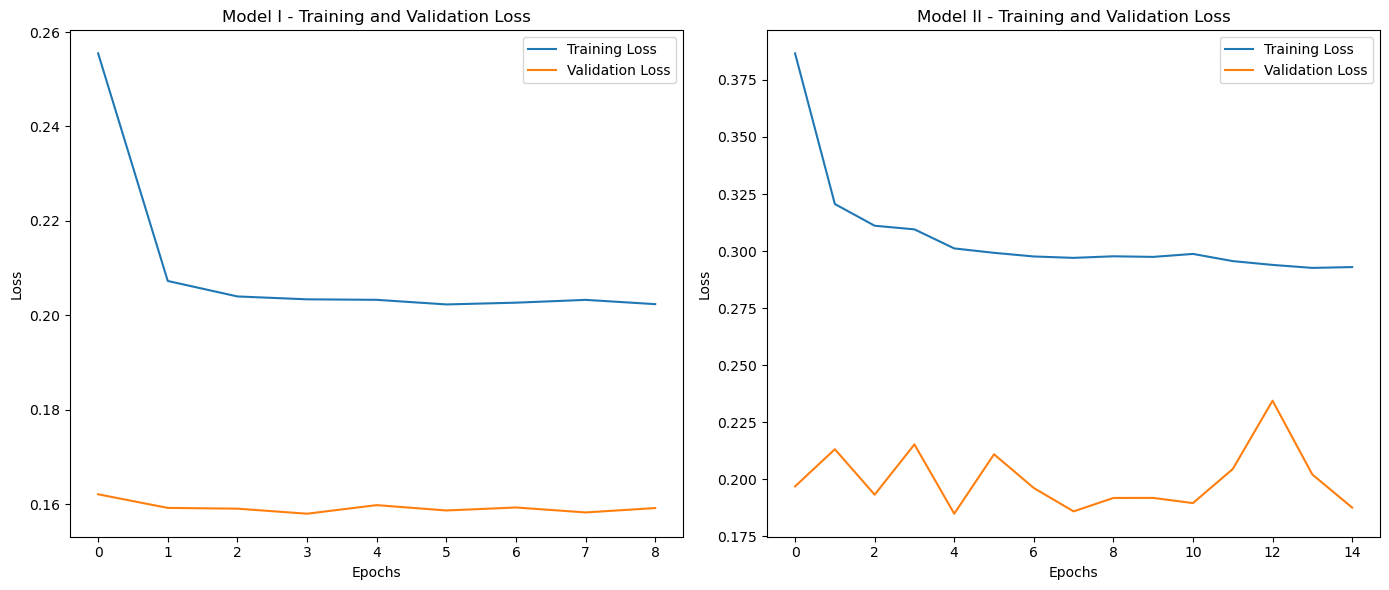

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Model I 
axes[0].plot(history_.history["loss"], label="Training Loss")
axes[0].plot(history_.history["val_loss"], label="Validation Loss")
axes[0].set_title("Model I - Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Model II
axes[1].plot(history.history["loss"], label="Training Loss")
axes[1].plot(history.history["val_loss"], label="Validation Loss")
axes[1].set_title("Model II - Training and Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

Both models experience large training losses initially, before they somewhat stagnate. The difference in how overfitting is handled between these two models is better shown in the respective validation losses. For the second model, the decrease in validation loss is more consistent with each epoch, thus signifying the model better generalizes compared the first model. ​

[Return to Top](#home)

### **Anomaly Detection** <a class="anchor" id="Anomaly"></a>

Reconstruction Loss Threshold <a class="anchor" id="Threshold"></a>

15476/15476 ━━━━━━━━━━━━━━━━━━━━ 3s 219us/step


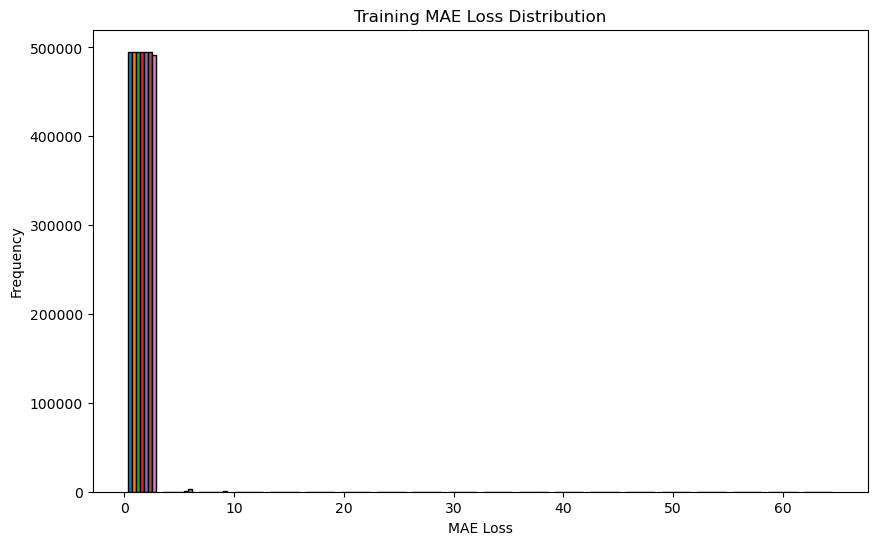

In [30]:
# Train MAE Loss
train_pred = model.predict(train_data)
train_mae_loss = np.mean(np.abs(train_pred - train_data), axis=1)

plt.figure(figsize=(10, 6))
plt.hist(train_mae_loss, bins=20, edgecolor='black')
plt.title('Training MAE Loss Distribution')
plt.xlabel('MAE Loss')
plt.ylabel('Frequency')
plt.show()

In [31]:
# Reconstruction Loss Threshold
threshold = np.max(train_mae_loss)
print("Reconstruction Error Threshold:", threshold.round(4))

Reconstruction Error Threshold: 64.8022


In [32]:
print("Shape of train_data:", train_data.shape)
print("Shape of train_pred:", train_pred.shape)

Shape of train_data: (495223, 1, 7)
Shape of train_pred: (495223, 1, 7)


3869/3869 ━━━━━━━━━━━━━━━━━━━━ 1s 226us/step


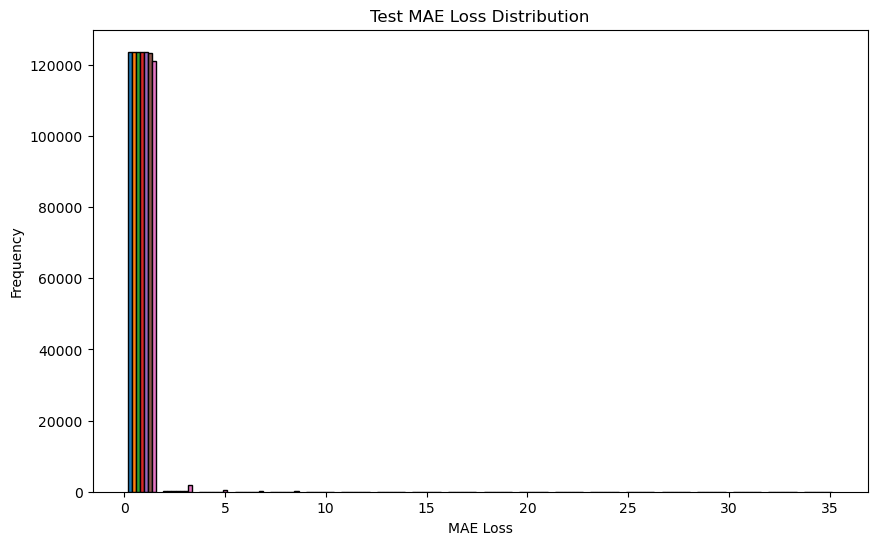

In [33]:
# Test MAE Loss
test_pred = model.predict(test_data)
test_mae_loss = np.mean(np.abs(test_pred - test_data), axis=1)

plt.figure(figsize=(10, 6))
plt.hist(test_mae_loss, bins=20, edgecolor='black')
plt.title('Test MAE Loss Distribution')
plt.xlabel('MAE Loss')
plt.ylabel('Frequency')
plt.show()

Evaluating Anomalies <a class="anchor" id="Evaluating"></a>

In [34]:
anomalies = test_mae_loss > threshold

if np.sum(anomalies) > 0:
    print("Number of Anomaly Samples: ", np.sum(anomalies))
    print("Indices of Anomaly Samples: ", np.where(anomalies))
else: 
    print("No Anomalies Detected in Data")

No Anomalies Detected in Data


[Return to Top](#home)

### **Results (Model Metrics & Accuracy)** <a class="anchor" id="Results"></a>

Error Metrics <a class="anchor" id="Error"></a>

In [35]:
MSE = mean_squared_error(train_data.flatten(), train_pred.flatten())
print("Model Mean Squared Error:", MSE.round(4))

Model Mean Squared Error: 0.1943


In [36]:
MAE = mean_absolute_error(train_data.flatten(), train_pred.flatten())
print("Model Mean Absolute Error:", MAE.round(4))

Model Mean Absolute Error: 0.2887


Overfitting/Underfitting Check II <a class="anchor" id="Check-II"></a>

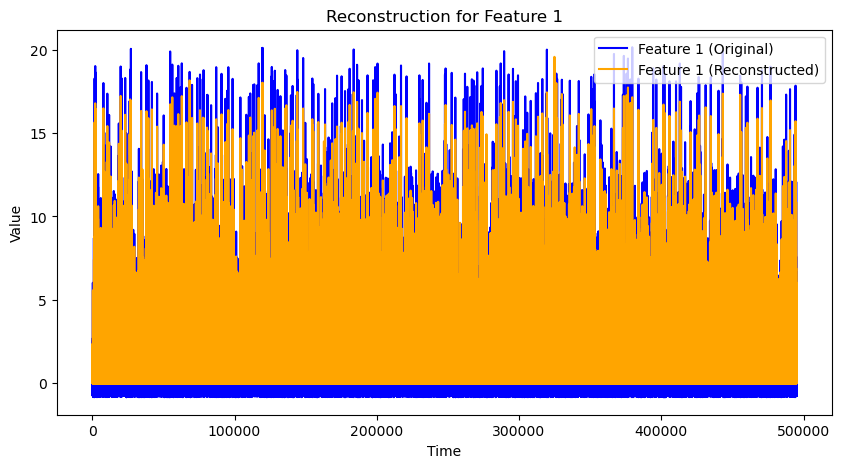

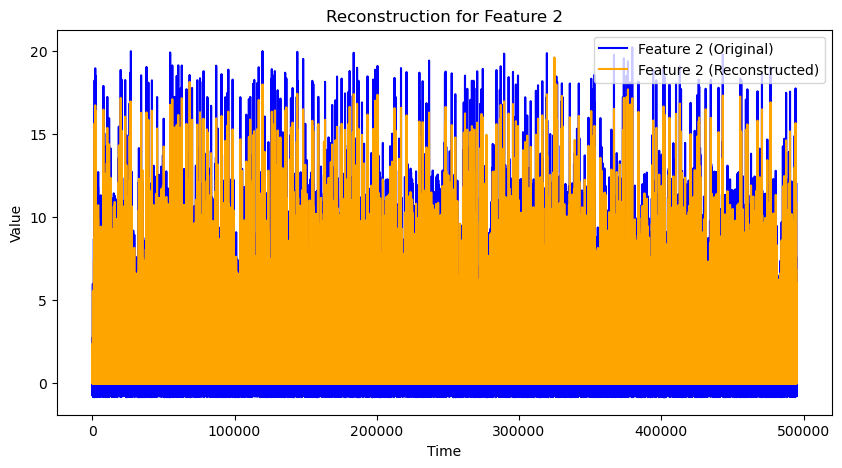

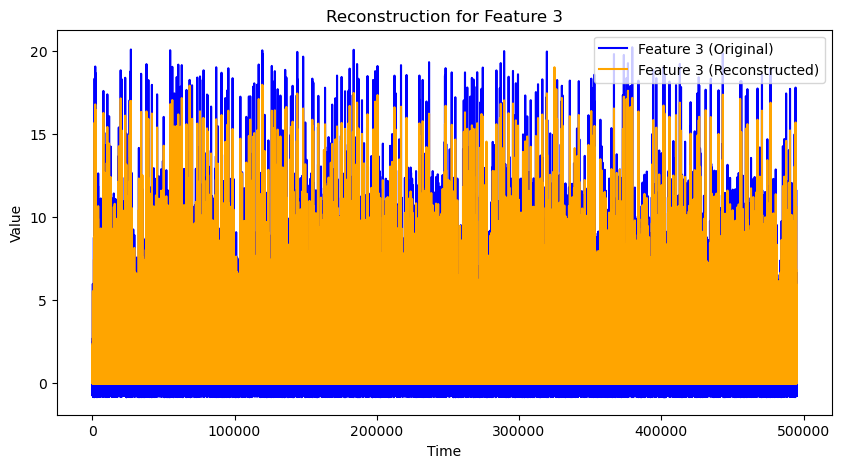

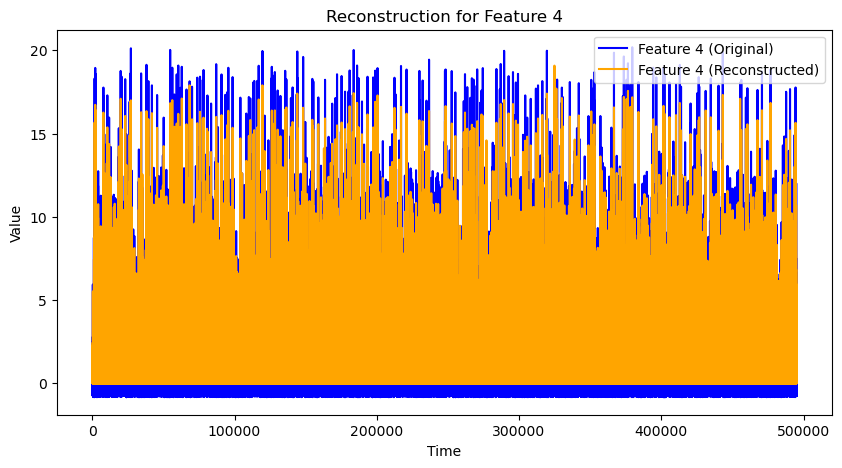

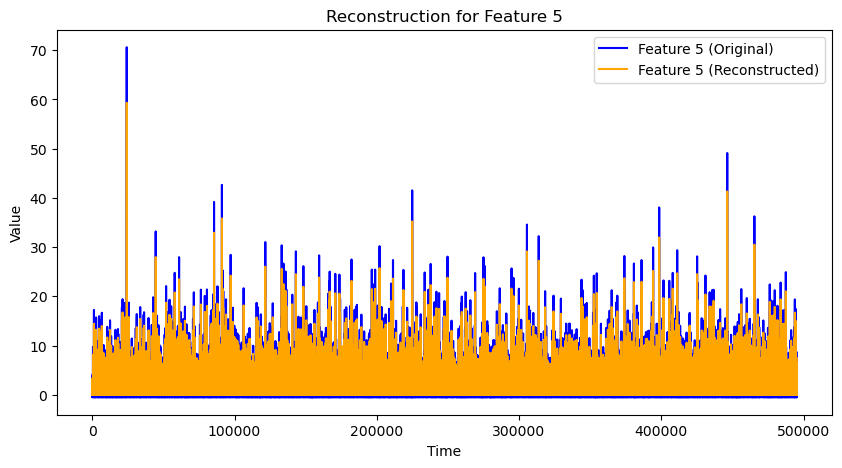

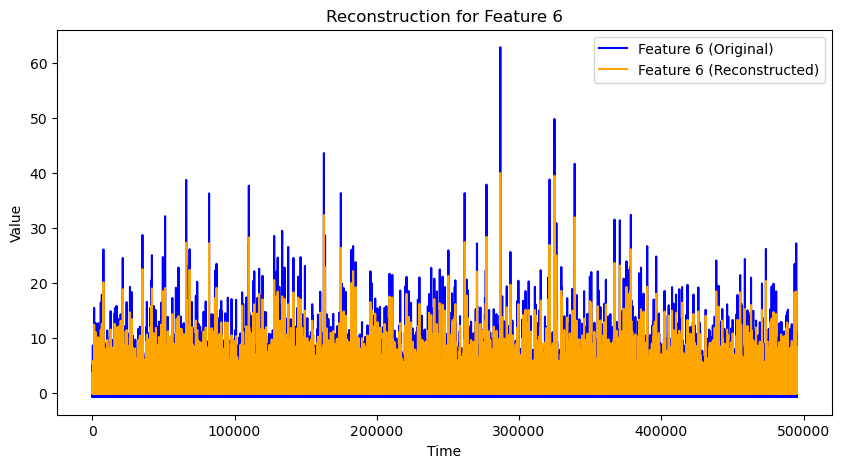

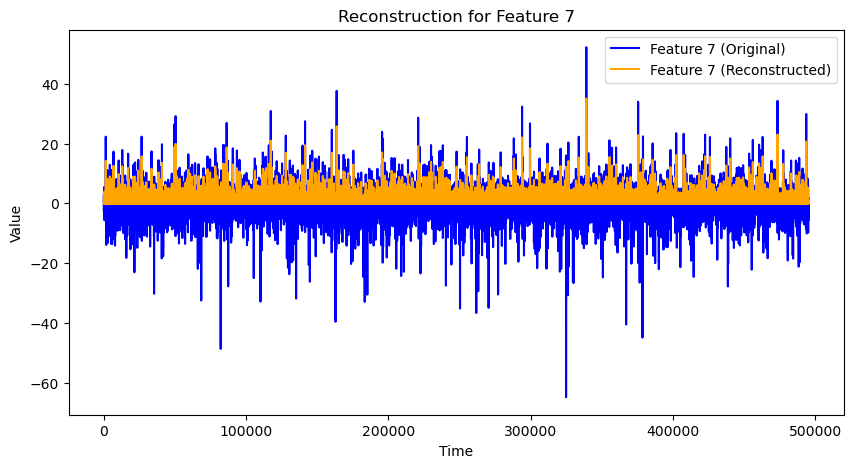

In [37]:
train_reshaped = np.reshape(train_data, (-1, 1, 7))

num_features = train_reshaped.shape[2]

for i in range(num_features):
    plt.figure(figsize=(10, 5))
    plt.plot(train_data[:, 0, i], label=f'Feature {i+1} (Original)', color='blue')
    plt.plot(train_pred[:, 0, i], label=f'Feature {i+1} (Reconstructed)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Reconstruction for Feature {i+1}')
    plt.legend()
    plt.show()

The reconstructions show that the model can reconstruct the original positive values for each of the features, sometimes a little too well, thereby being a sign of overfitting. The model, however, is unable to reconstruct negative values, which is a limitation.

In [38]:
warnings.filterwarnings("default")

[Return to Top](#home)